**Connect to Drive & Import Dependencies**

In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import folium

In [3]:
ROOT = ''
DATA_DIR = 'data/raw/'

**Assemble combined DP04 dataframe**

Data comes separated by year. This code reads each individual year's DP04 cvs, and concatenates all years into one dataframe, with an added column identifying the year.

In [4]:
dp04_all = pd.DataFrame()

for file in os.listdir(DATA_DIR):
  if file.endswith('Data.csv'):
    curr_df = pd.read_csv(os.path.join(DATA_DIR, file))
    curr_df['year'] = file[7:11]
    dp04_all = pd.concat([dp04_all, curr_df])

dp04_all.to_csv(ROOT + 'data/processed/dp04_all.csv', index=False)
dp04_all.head()

,GEO_ID,NAME,DP04_0001E,DP04_0001M,DP04_0001PE,DP04_0001PM,DP04_0002E,DP04_0002M,DP04_0002PE,DP04_0002PM,...,year,DP04_0142E,DP04_0142M,DP04_0143E,DP04_0143M,DP04_0142PE,DP04_0142PM,DP04_0143PE,DP04_0143PM,Unnamed: 574
0,Geography,Geographic Area Name,Estimate!!HOUSING OCCUPANCY!!Total housing units,Estimate Margin of Error!!HOUSING OCCUPANCY!!T...,Percent!!HOUSING OCCUPANCY!!Total housing units,Percent Margin of Error!!HOUSING OCCUPANCY!!To...,Estimate!!HOUSING OCCUPANCY!!Occupied housing ...,Estimate Margin of Error!!HOUSING OCCUPANCY!!O...,Percent!!HOUSING OCCUPANCY!!Occupied housing u...,Percent Margin of Error!!HOUSING OCCUPANCY!!Oc...,...,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1400000US06013301000,Census Tract 3010; Contra Costa County; Califo...,1769,129,1769,(X),1399,170,79.1,7.3,...,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1400000US06013302005,Census Tract 3020.05; Contra Costa County; Cal...,2321,93,2321,(X),2239,123,96.5,3.1,...,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1400000US06013302006,Census Tract 3020.06; Contra Costa County; Cal...,1365,58,1365,(X),1201,103,88.0,7.2,...,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1400000US06013302007,Census Tract 3020.07; Contra Costa County; Cal...,2080,112,2080,(X),1932,141,92.9,5.1,...,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Preparing/cleaning GRAPI data**
  1. Identify columns related to GRAPI (Gross rent as a percentage of income)
  2. Extract GRAPI count estimate columns
  3. Select and rename necessary columns
  4. Remove metadata row
  5. Convert estimate columns to numeric type

In [5]:
## Identify GRAPI columns
desc_row = dp04_all.iloc[0]

grapi_mask = desc_row.astype(str).str.contains("GROSS RENT AS A PERCENTAGE", case=False, na=False)
grapi_cols = dp04_all.columns[grapi_mask]
print("GRAPI columns found:")
print(grapi_cols.tolist())

GRAPI columns found:
['DP04_0134PM', 'DP04_0134E', 'DP04_0134M', 'DP04_0134PE', 'DP04_0135E', 'DP04_0135M', 'DP04_0135PE', 'DP04_0135PM', 'DP04_0136E', 'DP04_0136M', 'DP04_0136PE', 'DP04_0136PM', 'DP04_0137E', 'DP04_0137M', 'DP04_0137PE', 'DP04_0137PM', 'DP04_0138E', 'DP04_0138M', 'DP04_0138PE', 'DP04_0138PM', 'DP04_0139E', 'DP04_0139M', 'DP04_0139PE', 'DP04_0139PM', 'DP04_0140E', 'DP04_0140M', 'DP04_0140PE', 'DP04_0140PM', 'DP04_0141E', 'DP04_0141M', 'DP04_0141PE', 'DP04_0141PM']


In [6]:
## Create new dataframe with GEO_ID, NAME, year, and GRAPI columns
grapi_cols = [
    'DP04_0136E', 'DP04_0137E', 'DP04_0138E', 'DP04_0139E',
    'DP04_0140E', 'DP04_0141E', 'DP04_0142E', 'DP04_0143E',
    #'DP04_0136PE', 'DP04_0137PE', 'DP04_0138PE', 'DP04_0139PE',
    #'DP04_0140PE', 'DP04_0141PE', 'DP04_0142PE', 'DP04_0143PE'
]

grapi_counts = dp04_all[['GEO_ID', 'NAME', 'year'] + grapi_cols].copy()

## Rename columns for readability
grapi_colnames = {
    'DP04_0136E': 'total_renters_count', 'DP04_0136PE': 'total_renters_pct',
    'DP04_0137E': 'GRAPI_under_15_count', #'DP04_0137PE': 'GRAPI_under_15_pct',
    'DP04_0138E': 'GRAPI_15_to_19.9_count', #'DP04_0138PE': 'GRAPI_15_to_19.9_pct',
    'DP04_0139E': 'GRAPI_20_to_24.9_count', #'DP04_0139PE': 'GRAPI_20_to_24.9_pct',
    'DP04_0140E': 'GRAPI_25_to_29.9_count', #'DP04_0140PE': 'GRAPI_25_to_29.9_pct',
    'DP04_0141E': 'GRAPI_30_to_35_count', #'DP04_0141PE': 'GRAPI_30_to_35_pct',
    'DP04_0142E': 'GRAPI_35_or_greater_count', #'DP04_0142PE': 'GRAPI_35_or_greater_pct',
    'DP04_0143E': 'GRAPI_unknown_count', #'DP04_0143PE': 'GRAPI_unknown_pct'
}

## Remove metadata
grapi_counts = grapi_counts.rename(columns=grapi_colnames)
grapi_counts = grapi_counts[grapi_counts['GEO_ID'] != 'Geography']

## Convert estimates to numeric
estimate_cols = [column for column in grapi_counts.columns if column not in ['GEO_ID', 'NAME']]
grapi_counts[estimate_cols] = grapi_counts[estimate_cols].apply(pd.to_numeric, errors='coerce')

grapi_counts.to_csv(ROOT + 'data/processed/grapi_counts.csv', index=False)
grapi_counts.head()


,GEO_ID,NAME,year,total_renters_count,GRAPI_under_15_count,GRAPI_15_to_19.9_count,GRAPI_20_to_24.9_count,GRAPI_25_to_29.9_count,GRAPI_30_to_35_count,GRAPI_35_or_greater_count,GRAPI_unknown_count
1,1400000US06013301000,Census Tract 3010; Contra Costa County; Califo...,2010,20,0,76,0,105,53,NaN,NaN
2,1400000US06013302005,Census Tract 3020.05; Contra Costa County; Cal...,2010,0,26,76,53,328,40,NaN,NaN
3,1400000US06013302006,Census Tract 3020.06; Contra Costa County; Cal...,2010,23,14,12,13,37,0,NaN,NaN
4,1400000US06013302007,Census Tract 3020.07; Contra Costa County; Cal...,2010,90,68,15,64,381,77,NaN,NaN
5,1400000US06013302008,"Census Tract 3020.08, Contra Costa County, Cal...",2010,0,76,40,18,228,30,NaN,NaN


**Harmonize data to 2020 tracts**

Because we're analyzing census tract level data across different decades, we have to address the changing census tracts from 2010 vs. 2020. In order to do so, we'll use the census tract relationship file and harmonize all data into 2020 tract terms. We'll be using land area overlap to weight our count estimates, and recalculate percentages afterward.

1. Extract 11 digit GEOID
2. Separate GRAPI data by decade
3. Import relationship file
4. Clean relationship data by keeping relevant rows and converting to numeric
5. Add a column to the relationship data for weight, based on area overlap with the 2010s tract
6. Merge this with the 2010s GRAPI data by 2010 tract GEOID using an inner merge
7. Multiply every count column with the corresponding weight to obtain new weighted columns
8. Aggregate by 2020 tract GEOID and sum the weighted counts
9. Clean up columns, and concatenate with 2020s GRAPI data.

In [7]:
count_cols = [column for column in grapi_counts.columns if column.endswith('count')]

## Standardize 11 digit GEOID and split data by decade
grapi_work = grapi_counts.copy()

grapi_work['GEOID'] = grapi_work['GEO_ID'].str[-11:]

grapi_2010s = grapi_work[grapi_work['year'] <= 2019]
grapi_2020s = grapi_work[grapi_work['year'] >= 2020]


## Load in relationship file and clean
xwalk = pd.read_csv(DATA_DIR + 'tab20_tract20_tract10_st06.txt',
                           sep='|',
                           dtype=str,
                           encoding="utf-8")

xwalk = xwalk[["GEOID_TRACT_20", "GEOID_TRACT_10",
               "AREALAND_TRACT_20", "AREALAND_TRACT_10",
               "AREALAND_PART"]].copy()

for c in ["AREALAND_TRACT_20", "AREALAND_TRACT_10", "AREALAND_PART"]:
  xwalk[c] = pd.to_numeric(xwalk[c], errors="coerce")

## Add area-based weight: fraction of each 2010 tract's land that intersects a 2020 tract
xwalk["w_area10_to20"] = np.where(
    xwalk["AREALAND_TRACT_10"] > 0,
    xwalk["AREALAND_PART"] / xwalk["AREALAND_TRACT_10"],
    0.0
)

## Merge the 2010s data to the relationship file by 2010 GEOID
grapi_2010s = grapi_2010s.rename(columns={'GEOID': 'GEOID_TRACT_10'})
xwalk_2010s_m = grapi_2010s.merge(xwalk, on="GEOID_TRACT_10", how="inner")

## Weight all count columns by overlap area as {column}_weighted
for column in count_cols:
  if column in xwalk_2010s_m.columns:
    xwalk_2010s_m[column + '_weighted'] = xwalk_2010s_m[column].astype(float) * xwalk_2010s_m["w_area10_to20"]


## Aggregate by year and 2020 tract, sum weighted columns
group_keys = ["GEOID_TRACT_20", "year"]
weighted_cols = [c + "_weighted" for c in count_cols if (c + "_weighted") in xwalk_2010s_m.columns]

harm_2010s = (
    xwalk_2010s_m
      .groupby(group_keys, as_index=False)[weighted_cols]
      .sum()
)

## Clean up columns
harm_2010s = harm_2010s.rename(
    columns={c+"_weighted": c for c in count_cols if (c + "_weighted") in xwalk_2010s_m.columns}
)

harm_2010s = harm_2010s.rename(columns={"GEOID_TRACT_20": "GEOID"})



## Consolidate 2020s data columns and concatenate with harmonized 2010s data
keep_cols = ["GEOID", "year"] + count_cols
grapi_2020s = grapi_2020s[keep_cols].copy()

grapi_harmonized_counts = (
    pd.concat([harm_2010s[keep_cols], grapi_2020s], ignore_index=True)
      .sort_values(["year", "GEOID"])
      .reset_index(drop=True)
)


grapi_harmonized_counts.head()

,GEOID,year,total_renters_count,GRAPI_under_15_count,GRAPI_15_to_19.9_count,GRAPI_20_to_24.9_count,GRAPI_25_to_29.9_count,GRAPI_30_to_35_count,GRAPI_35_or_greater_count,GRAPI_unknown_count
0,06001400100,2010,0.000000,0.000000,0.021257,0.000000,0.028213,0.000179,0.0,0.0
1,06001404400,2010,0.000000,0.000000,0.005623,0.000000,0.016400,0.005154,0.0,0.0
2,06001404502,2010,0.038819,0.025879,0.038205,0.017916,0.097414,0.014036,0.0,0.0
3,06001404600,2010,0.011556,0.007704,0.010371,0.005334,0.026076,0.003260,0.0,0.0
4,06001430101,2010,0.308388,0.130782,0.216563,0.064074,0.452100,0.085140,0.0,0.0


**Identify missing data in the column of interest**

**Remove the years that have missing data**

We find that the data from 2010-2014 have all missing values in the GRAPI of 35 or higher column, which is concerning because this is our primary column of interest.

Instead of focussing on 2010-2017 as our pre-treatment period, we will reduce it to 2015-2017. Since this still spans multiple years, it should still be sufficient for our analysis as it will allow us to examine previous trends.

In [8]:
for year in grapi_harmonized_counts['year'].unique():
  print(f"Year: {year}, sum: {grapi_harmonized_counts[grapi_harmonized_counts['year']==year]['GRAPI_35_or_greater_count'].sum()}")

Year: 2010, sum: 0.0
Year: 2011, sum: 0.0
Year: 2012, sum: 0.0
Year: 2013, sum: 0.0
Year: 2014, sum: 0.0
Year: 2015, sum: 58896.0
Year: 2016, sum: 58292.0
Year: 2017, sum: 56431.0
Year: 2018, sum: 56496.0
Year: 2019, sum: 55740.0
Year: 2020, sum: 54628.0
Year: 2021, sum: 56809.0
Year: 2022, sum: 57651.0
Year: 2023, sum: 57968.0


In [9]:
grapi_harmonized_counts = grapi_harmonized_counts[grapi_harmonized_counts['year'] > 2014]

grapi_harmonized_counts.to_csv(ROOT + 'data/processed/grapi_harmonized_counts.csv', index=False)
grapi_harmonized_counts['year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

**Compute percentage estimates with new tracts**

Since we weighted counts based on the tract relationship file, the percentage estimates from the data are no longer reliable. We will simply recalcluate the percentages based on count / total renters, which are both now weighted. This will create a corresponding percent column for each count column.

In [10]:
def pct_estimate(df):
  for column in df.columns:
    if column.endswith('count') and column not in ['GEOID', 'year', 'total_renters_count', 'GRAPI_unknown_count']:
      df[column[:-5] + 'pct'] = df[column] / df['total_renters_count']
  df[[column for column in df.columns if column.endswith('pct')]] = df[[column for column in df.columns if column.endswith('pct')]].fillna(0)
  return df

grapi_harmonized = pct_estimate(grapi_harmonized_counts)

grapi_harmonized.to_csv(ROOT + 'data/processed/grapi_harmonized.csv', index=False)
grapi_harmonized.head()


,GEOID,year,total_renters_count,GRAPI_under_15_count,GRAPI_15_to_19.9_count,GRAPI_20_to_24.9_count,GRAPI_25_to_29.9_count,GRAPI_30_to_35_count,GRAPI_35_or_greater_count,GRAPI_unknown_count,GRAPI_under_15_pct,GRAPI_15_to_19.9_pct,GRAPI_20_to_24.9_pct,GRAPI_25_to_29.9_pct,GRAPI_30_to_35_pct,GRAPI_35_or_greater_pct
1245,06001400100,2015,0.049861,0.000407,0.023694,0.000309,0.010840,0.007898,0.006712,0.009328,0.008165,0.475205,0.006206,0.217408,0.158402,0.134614
1246,06001404400,2015,0.033268,0.011714,0.000000,0.008903,0.008903,0.000000,0.003748,0.003280,0.352113,0.000000,0.267606,0.267606,0.000000,0.112676
1247,06001404502,2015,0.181175,0.037872,0.029861,0.007323,0.020263,0.027870,0.057985,0.052728,0.209039,0.164818,0.040420,0.111841,0.153830,0.320052
1248,06001404600,2015,0.048004,0.009186,0.008890,0.000593,0.004445,0.008297,0.016594,0.015112,0.191358,0.185185,0.012346,0.092593,0.172840,0.345679
1249,06001430101,2015,3.435010,0.225747,0.671398,0.515465,0.262341,0.361458,1.398602,0.188207,0.065719,0.195457,0.150062,0.076373,0.105227,0.407161


**Merge with geographical data**

To deal with our spacial analysis, we must merge our Contra Costa County tract data with this 2020 Cartographic Boundary File (SHP), Current Census Tract for California from the US Census Bureau. We'll load in the shapefile as a GeoDataFrame and inner merge it with our harmonized GRAPI data.

In [11]:
## Load in GeoDataFrame
ca_tracts = gpd.read_file(DATA_DIR + "cb_2020_06_tract_500k.zip")

## Perform inner merge on GEOID
grapi_geo = ca_tracts.merge(grapi_harmonized, left_on='GEOID', right_on='GEOID', how='inner')
grapi_geo.to_file(ROOT + 'data/processed/grapi_geo.geojson', driver='GeoJSON')


## Verify with a simple map
grapi_geo[grapi_geo['year']==2017].explore(column='GRAPI_35_or_greater_pct', legend=True, cmap='Reds')

**Add BART geographical data**

To analyze the effects the BART station may have had on nearby areas, we must bring in the location of the BART station as a point. The file "stops.txt" is obtained from BART's GTFS Schedules page, and contains the latitude and longitude of BART stations. We can use this to filter down to a GeoDataFrame with only one row, representing the Antioch BART station.

In [12]:
stops = pd.read_csv(DATA_DIR + "stops.txt")

antioch = stops[stops['stop_name'].str.contains('Antioch', case=False, na=False)].copy()
antioch_geo = gpd.GeoDataFrame(antioch,
                               geometry=[Point(xy) for xy in zip(antioch['stop_lon'], antioch['stop_lat'])],
                               crs = grapi_geo.crs
                               )

antioch_geo = antioch_geo.iloc[2:]

antioch_geo.to_file(ROOT + 'data/processed/antioch_geo.geojson', driver='GeoJSON')

antioch_geo

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,plc_url,location_type,parent_station,platform_code,geometry
151,ANTC,908309.0,Antioch,NaN,37.995373,-121.780346,ANTC,https://www.bart.gov/stations/antc,1,NaN,NaN,POINT (-121.78035 37.99537)


**Identify Region of Interest**

We are going to compare changes within 2 miles of the BART station against changes between 2 and 5 miles away. For this, we will create 2 buffers around the BART station (2 miles and 5 miles), and perform a spacial join with the 5 mile buffer to filter down our data to only our area of interest. We'll identify a tract's distance from the BART station by centrioid.

In [13]:
## Reproject to a meters-based CRS instead of degrees
antioch_geo_m = antioch_geo.to_crs(26910)

## Establish buffers
buff2mi = gpd.GeoDataFrame(geometry=antioch_geo_m.buffer(2*1609))
buff5mi = gpd.GeoDataFrame(geometry=antioch_geo_m.buffer(5*1609))


## Reproject
grapi_geo_m = grapi_geo.to_crs(antioch_geo_m.crs)


## GeoDataFrame representing centroids of tracts
grapi_geo_centroids = grapi_geo_m.copy()
grapi_geo_centroids['geometry'] = grapi_geo_centroids['geometry'].centroid

## Filter down to centroids within 5 miles of BART
grapi_5mi_centroids = gpd.sjoin(grapi_geo_centroids, buff5mi, how='inner', predicate='within')

## Match up tract geometries with their centrioids
grapi_5mi = grapi_geo_m.loc[grapi_geo_m['GEOID'].isin(grapi_5mi_centroids['GEOID'])]

## Save files to processed directory
antioch_geo_m.to_file(ROOT + 'data/processed/antioch_geo_m.geojson', driver='GeoJSON')
buff2mi.to_file(ROOT + 'data/processed/buff2mi.geojson', driver='GeoJSON')
buff5mi.to_file(ROOT + 'data/processed/buff5mi.geojson', driver='GeoJSON')
grapi_geo_m.to_file(ROOT + 'data/processed/grapi_geo_m.geojson', driver='GeoJSON')
grapi_5mi_centroids.to_file(ROOT + 'data/processed/grapi_5mi_centroids.geojson', driver='GeoJSON')
grapi_5mi.to_file(ROOT + 'data/processed/grapi_5mi.geojson', driver='GeoJSON')

## Preview with a map
m = grapi_5mi[grapi_5mi['year']==2015].explore(column='GRAPI_35_or_greater_pct',
                                                 cmap='Reds')
buff2mi.explore(m=m, style_kwds=dict(fill=False, weight=3))
buff5mi.explore(m=m, style_kwds=dict(fill=False, weight=3))
grapi_5mi_centroids.explore(m=m)

m

**Visualizations**


This map shows the difference between GRAPI>35% as a percentage in 2019 and 2017. A darker red means that the percentage of people spending more than 35% of their income on rent has increased more.

In [14]:
grapi_2019 = grapi_5mi[grapi_5mi['year'] == 2019]
grapi_2017 = grapi_5mi[grapi_5mi['year'] == 2017]


grapi_2019_2017 = grapi_2019.sjoin(grapi_2017, predicate='within')
grapi_2019_2017['35_or_greater_diff'] = grapi_2019_2017['GRAPI_35_or_greater_pct_left'] - grapi_2019_2017['GRAPI_35_or_greater_pct_right']



m = grapi_2019_2017.explore(column='35_or_greater_diff',
                            cmap='RdBu_r',
                            tooltip=['GEOID_left', '35_or_greater_diff'],
                            tiles="CartoDB positron",
                            style_kwds={"color": "black",
                                        "weight": 1,
                                        "fillOpacity": 0.7},
                            tooltip_kwds={"aliases": ['Tract GEOID:','Change in percentage:']},
                            legend_kwds={"caption": "Change in GRAPI ≥ 35% (percentage points)"},
                            scheme="Quantiles")

buff2mi.explore(m=m,
                style_kwds=dict(fill=False, weight=2),
                color='black',
                tooltip=False,
                name='2 mile buffer')

buff5mi.explore(m=m,
                style_kwds=dict(fill=False, weight=2),
                color='black',
                tooltip=False,
                name='5 mile buffer')

grapi_5mi_centroids.explore(m=m,
                            color='grey',
                            tooltip=False,
                            name='Tract centroid')

antioch_geo_m.explore(m=m,
                      color='black',
                      tooltip=False,
                      name='BART station')
title_html = """
     <h3 align="center" style="font-size:20px"><b>
        Difference between percentage of GRAPI>35% in 2019 and GRAPI>35% in 2017
     </b></h3>
     """

caption_html = """
<div style="
     position: fixed;
     bottom: 10px;
     left: 10px;
     z-index: 9999;
     background-color: rgba(255, 255, 255, 0.9);
     padding: 10px 15px;
     border-radius: 8px;
     box-shadow: 0 0 5px rgba(0,0,0,0.3);
     font-size: 12px;
     max-width: 350px;
">
  <b>Figure:</b> This map compares the share of difference in percentage points of renter households paying more than 35% of income on gross rent (GRAPI ≥ 35%)
  from 2017 to 2019.
  Darker red tracts indicate larger increases in percentage of rent burdened households, highlighting areas where housing cost pressures intensified, while blue indicates a decrease in
  percentage of cost-burdened households. The black point is the location of the Antioch BART station, the inner ring is a 2 mile buffer, and the outer
  ring is a 5 mile buffer. The grey points are the centroids of each tract, which are used to calculate each tract's from the station in our analysis.
  <br><br>
  <b>Data sources:</b> ACS 1-year estimates (Table DP04, 2017 & 2019); 2020 Census tracts (Cartographic Boundary Files); BART station location for Antioch.
</div>
"""

m.get_root().html.add_child(folium.Element(caption_html))
m.get_root().html.add_child(folium.Element(title_html))

m.save(ROOT + 'visualizations/GRAPI_diff.html')
m

This scatterplot shows the difference in GRAPI>35% between 2019 and 2017 and its relationship with distance from the Antioch BART station. From this, we do not see a very significant relationship immediately.

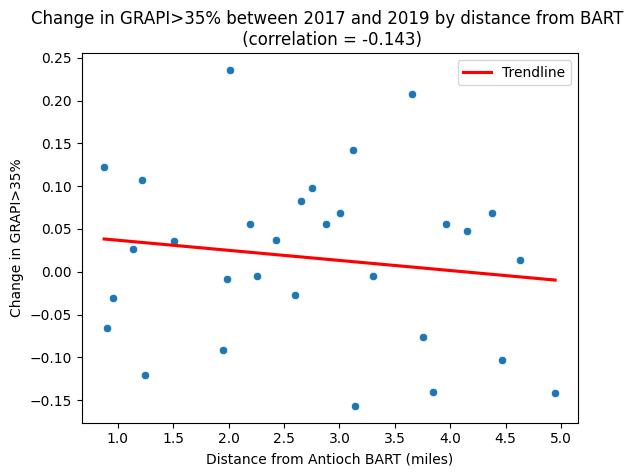

In [15]:
grapi_2019_2017['distance'] = grapi_2019_2017.centroid.distance(antioch_geo_m.geometry.iloc[0])
grapi_2019_2017['distance_mi'] = grapi_2019_2017['distance'] / 1609

grapi_2019_2017.to_file(ROOT + 'data/processed/grapi_2019_2017.geojson', driver='GeoJSON')


ax = sns.scatterplot(data=grapi_2019_2017, x='distance_mi', y='35_or_greater_diff')
sns.regplot(data=grapi_2019_2017,
            x='distance_mi', y='35_or_greater_diff',
            scatter=False,
            ax=ax,
            label='Trendline',
            ci=None,
            line_kws={"color": "red"})

ax.legend()

plt.xlabel('Distance from Antioch BART (miles)')
plt.ylabel('Change in GRAPI>35%')
plt.title(f"Change in GRAPI>35% between 2017 and 2019 by distance from BART \n (correlation = {round(grapi_2019_2017['distance_mi'].corr(grapi_2019_2017['35_or_greater_diff']), 3)})")

plt.savefig(ROOT + 'visualizations/GRAPI_diff_scatter_17_19.png')
plt.show()

For comparison, this scatterplot shows the difference in GRAPI>35 percentage from 2015 to 2023. When we expand the timeframe, it does appear to show a very slight negative relationship. This shows potential for further analysis.

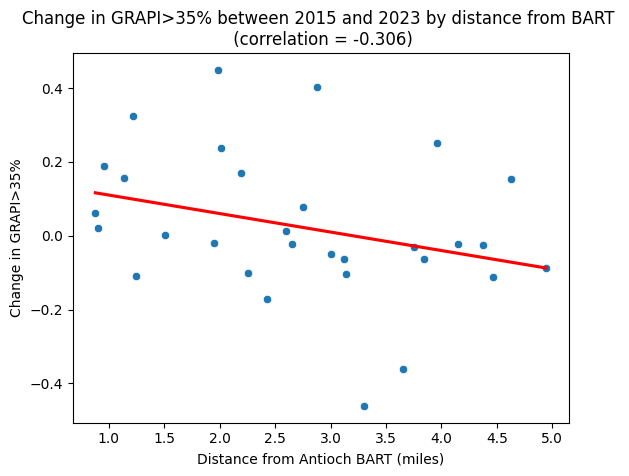

In [16]:
grapi_2023 = grapi_5mi[grapi_5mi['year'] == 2023]
grapi_2015 = grapi_5mi[grapi_5mi['year'] == 2015]


grapi_2023_2015 = grapi_2023.sjoin(grapi_2015, predicate='within')
grapi_2023_2015['35_or_greater_diff'] = grapi_2023_2015['GRAPI_35_or_greater_pct_left'] - grapi_2023_2015['GRAPI_35_or_greater_pct_right']
grapi_2023_2015['distance'] = grapi_2023_2015.centroid.distance(antioch_geo_m.geometry.iloc[0])
grapi_2023_2015['distance_mi'] = grapi_2023_2015['distance'] / 1609

grapi_2023_2015.to_file(ROOT + 'data/processed/grapi_2023_2015.geojson', driver='GeoJSON')


ax = sns.scatterplot(data=grapi_2023_2015, x='distance_mi', y='35_or_greater_diff')
sns.regplot(data=grapi_2023_2015,
            x='distance_mi', y='35_or_greater_diff',
            scatter=False,
            ax=ax,
            label='Trendline',
            ci=None,
            line_kws={"color": "red"})

plt.xlabel('Distance from Antioch BART (miles)')
plt.ylabel('Change in GRAPI>35%')
plt.title(f"Change in GRAPI>35% between 2015 and 2023 by distance from BART \n (correlation = {round(grapi_2023_2015['distance_mi'].corr(grapi_2023_2015['35_or_greater_diff']), 3)})")

plt.savefig(ROOT + 'visualizations/GRAPI_diff_scatter_15_23.png')
plt.show()

This bar chart shows the distribution of households across the GRAPI bins, over the entire 5 mile radius. It shows a comparison between 2017 and 2019.

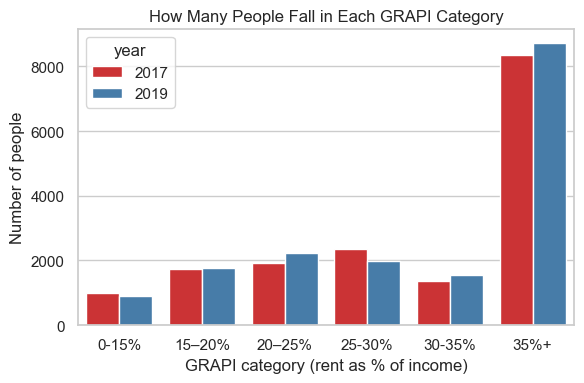

In [17]:
long_2017_counts = grapi_2017[['GEOID', 'GRAPI_under_15_count', 'GRAPI_15_to_19.9_count',
                               'GRAPI_20_to_24.9_count', 'GRAPI_25_to_29.9_count',
                               'GRAPI_30_to_35_count', 'GRAPI_35_or_greater_count']].melt(
                                   id_vars=['GEOID'],
                                   value_vars=['GRAPI_under_15_count', 'GRAPI_15_to_19.9_count',
                                               'GRAPI_20_to_24.9_count', 'GRAPI_25_to_29.9_count',
                                               'GRAPI_30_to_35_count', 'GRAPI_35_or_greater_count'],
                                   var_name='GRAPI_bin',
                                   value_name='count'
)
bin_totals_2017 = (
    long_2017_counts.groupby("GRAPI_bin", observed=True)["count"]
        .sum()
        .reset_index()
)
label_map = {
    'GRAPI_under_15_count': "0-15%",
    'GRAPI_15_to_19.9_count': "15–20%",
    'GRAPI_20_to_24.9_count': "20–25%",
    'GRAPI_25_to_29.9_count': "25-30%",
    'GRAPI_30_to_35_count': "30-35%",
    'GRAPI_35_or_greater_count': "35%+"
}

bin_totals_2017["label"] = bin_totals_2017["GRAPI_bin"].map(label_map)
bin_totals_2017['year'] = 2017

long_2019_counts = grapi_2019[['GEOID', 'GRAPI_under_15_count', 'GRAPI_15_to_19.9_count',
                               'GRAPI_20_to_24.9_count', 'GRAPI_25_to_29.9_count',
                               'GRAPI_30_to_35_count', 'GRAPI_35_or_greater_count']].melt(
                                   id_vars=['GEOID'],
                                   value_vars=['GRAPI_under_15_count', 'GRAPI_15_to_19.9_count',
                                               'GRAPI_20_to_24.9_count', 'GRAPI_25_to_29.9_count',
                                               'GRAPI_30_to_35_count', 'GRAPI_35_or_greater_count'],
                                   var_name='GRAPI_bin',
                                   value_name='count'
                               )

bin_totals_2019 = (
    long_2019_counts.groupby("GRAPI_bin", observed=True)["count"]
        .sum()
        .reset_index()
)


bin_totals_2019["label"] = bin_totals_2019["GRAPI_bin"].map(label_map)

bin_totals_2019['year'] = 2019

bin_totals_2019_2017 = pd.concat([bin_totals_2017, bin_totals_2019])


sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.barplot(
    data=bin_totals_2019_2017,
    x="label",
    y="count",
    hue='year',
    palette="Set1",
    order=['0-15%','15–20%','20–25%','25-30%','30-35%','35%+']
)

plt.xlabel("GRAPI category (rent as % of income)")
plt.ylabel("Number of people")
plt.title("How Many People Fall in Each GRAPI Category")

plt.tight_layout()

plt.savefig(ROOT + 'visualizations/GRAPI_bin_bar.png')
plt.show()

**Difference-in-Differences Analysis**
  
  Typically, a DiD analysis would be used to reasonably isolate
  the causal effect of the BART station's construction on nearby cost pressures. In reality, external factors and data limitations will limit our ability to attribute causality, but it will still be useful to analyze correlation. In the cells below, we add the necessary synthetic variables: Distance and distance_mi calculate how far the centroid of each tract is from the station, post (0 or 1) to signify whether or not the observation is before or after 2018, treat (0 or 1) for whether the distance is under 2 miles from the stations, and treat_post (treat*post) which tell us whether an observation is in the treatment AND post group.

  We then run a regression predicting percentage of households with GRAPI 35 or greater based on treat, post, and treat_post. From the results, the coefficient on treat_post is what interests us.

In [18]:
grapi_did = grapi_5mi.copy()

## Create synthetic variables
grapi_did['distance'] = grapi_did.centroid.distance(antioch_geo_m.geometry.iloc[0])
grapi_did['distance_mi'] = grapi_did['distance'] / 1609

grapi_did['treat'] = grapi_did['distance_mi'].apply(lambda x: 1 if x < 2 else 0)
grapi_did['post'] = grapi_did['year'].apply(lambda x: 1 if x > 2018 else 0)
grapi_did['treat_post'] = grapi_did['treat'] * grapi_did['post']

## Remove 2018, because sation opened in the middle of the year
grapi_did_no2018 = grapi_did[grapi_did['year'] != 2018]

grapi_did_no2018.to_file(ROOT + 'data/processed/grapi_did_no2018.geojson', driver='GeoJSON')

grapi_did_no2018[['GEOID', 'year', 'distance_mi', 'treat', 'post', 'treat_post']].head()


,GEOID,year,distance_mi,treat,post,treat_post
72,06013302009,2015,2.423898,0,0,0
73,06013302009,2016,2.423898,0,0,0
74,06013302009,2017,2.423898,0,0,0
76,06013302009,2019,2.423898,0,1,0
77,06013302009,2020,2.423898,0,1,0


In [19]:
import statsmodels.formula.api as smf

did1 = smf.ols("GRAPI_35_or_greater_pct ~ treat + post + treat_post", data=grapi_did_no2018).fit()
print(did1.summary())

                               OLS Regression Results                              
Dep. Variable:     GRAPI_35_or_greater_pct   R-squared:                       0.007
Model:                                 OLS   Adj. R-squared:                 -0.006
Method:                      Least Squares   F-statistic:                    0.5426
Date:                     Mon, 15 Dec 2025   Prob (F-statistic):              0.654
Time:                             23:12:58   Log-Likelihood:                 123.42
No. Observations:                      240   AIC:                            -238.8
Df Residuals:                          236   BIC:                            -224.9
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
In

**Additional Visualizations**


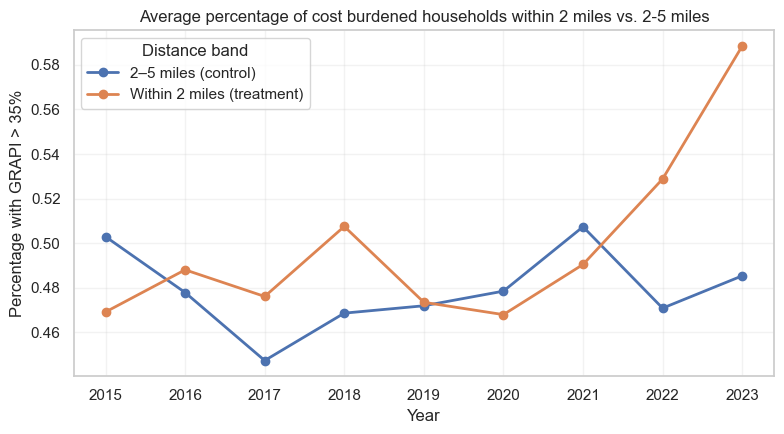

In [20]:
grapi_grouped = (grapi_did[['GRAPI_35_or_greater_pct', 'treat', 'year']]
                 .groupby(['treat','year']).mean()
                 .reset_index()
                 .sort_values(["treat", "year"]))


name_map = {
    0: "2–5 miles (control)",
    1: "Within 2 miles (treatment)",
    "0": "2–5 miles (control)",
    "1": "Within 2 miles (treatment)",
}

fig, ax = plt.subplots(figsize=(8, 4.5))

for treat_val, g in grapi_grouped.groupby("treat"):
    ax.plot(
        g["year"],
        g["GRAPI_35_or_greater_pct"],
        marker="o",
        linewidth=2,
        label=name_map.get(treat_val, str(treat_val)),
    )

ax.set_title("Average percentage of cost burdened households within 2 miles vs. 2-5 miles")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage with GRAPI > 35%")
ax.legend(title="Distance band")
ax.grid(True, alpha=0.25)

plt.savefig(ROOT + 'visualizations/GRAPI_time_series_by_group.png')

plt.tight_layout()
plt.show()

In [21]:
m = grapi_5mi[grapi_5mi['year'] == max(grapi_5mi['year'])].explore(
    column='GRAPI_35_or_greater_pct',
    cmap='Reds',
    tooltip=['GEOID', 'GRAPI_35_or_greater_pct'],
    tiles="CartoDB positron",
    style_kwds={"color": "black",
                "weight": 1,
                "fillOpacity": 0.7},
    tooltip_kwds={"aliases": ['Tract GEOID:','Percentage of households with GRAPI ≥ 35%:']},
    legend_kwds={"caption": "Percentage of households with GRAPI ≥ 35%"}
)

title_html = """
     <h3 align="center" style="font-size:20px"><b>
        2023 GRAPI ≥ 35% percentage by tract
     </b></h3>
     """

caption_html = """
<div style="
     position: fixed;
     bottom: 10px;
     left: 10px;
     z-index: 9999;
     background-color: rgba(255, 255, 255, 0.9);
     padding: 10px 15px;
     border-radius: 8px;
     box-shadow: 0 0 5px rgba(0,0,0,0.3);
     font-size: 12px;
     max-width: 350px;
">
  <b>Figure:</b> This heatmap shows the percentage of households in each tract with gross rent as a percentage of income (GRAPI) ≥ 35% as it
  stands in the year 2023, the most up-to-date year accessible. This allows us to see the spacial distribution of cost-burdened households.
  <br><br>
  <b>Data sources:</b> ACS 1-year estimates (Table DP04, 2023); 2020 Census tracts (Cartographic Boundary Files).
</div>
"""

m.get_root().html.add_child(folium.Element(caption_html))
m.get_root().html.add_child(folium.Element(title_html))

m.save(ROOT + 'visualizations/GRAPI_2023_map.html')

m